# Apply Clustering Algorithm to Policy Text Embeddings 
* Test using K-Means clustering
* Algortihm uses euclidean distance to measure similarity between data points - which is exactly what we want to do here, when determining how closely they sit in the vectorised space
* Although K means performs poorly on this high dimensionality space

In [3]:
import configparser
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, AgglomerativeClustering

import warnings 
import ast
warnings.filterwarnings('ignore')

In [4]:
config = configparser.ConfigParser()
config.read("config.ini")

# access values
raw_path = Path(config["default"]["raw_path"])
interim_path = Path(config["default"]["interim_path"])
processed_path = Path(config["default"]["processed_path"])

In [5]:
df = pd.read_csv(interim_path/"policy_embeddings_country.csv") #policy_embeddings.csv
df

,country,text_clean,embeddings
0,Austria,federal purchase subsidy scheme e mobilität 20...,"[-0.03710819408297539, 0.02366330847144127, 0...."
1,Belgium,regional purchase subsidies are no longer avai...,"[-0.0001772841642377898, 0.028538541868329048,..."
2,Bulgaria,no purchase subsidies are currently available ...,"[-0.04008038714528084, 0.0288896132260561, 0.0..."
3,Croatia,call for investment in zero emission vehicles ...,"[-0.003128104144707322, 0.044598959386348724, ..."
4,Cyprus,under national electromobility promotion schem...,"[-0.025078408420085907, 0.06687013059854507, -..."
5,Czech Republic,no purchase subsidies available in 2025 bevs f...,"[-0.04738859832286835, 0.05021532252430916, -0..."
6,Denmark,no direct national purchase subsidies are avai...,"[-0.06332932412624359, 0.05011808127164841, 0...."
7,Estonia,since december 2023 estonia no longer offers d...,"[-0.029093794524669647, 0.003588747698813677, ..."
8,Finland,2025 finland does not offer direct purchase su...,"[-0.06467203795909882, 0.0142294242978096, 0.0..."
9,France,ecological bonus bonus écologique remains in p...,"[0.018083663657307625, 0.05167808011174202, 0...."


Get embeddings in correct format for clustering

In [6]:
print(type(df["embeddings"].iloc[0]))

<class 'str'>


In [7]:
# need to parse embeddings array back to a list
# convert embeddings column - currently stored as string - to list of floats

df["embeddings"]=df["embeddings"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


In [8]:
# stack embeddings vectors into 2D matrix so it can be processed 

X = np.vstack(df["embeddings"].apply(np.array))

print("Matrix shape:", X.shape)
print("Type:", type(X))

Matrix shape: (33, 384)
Type: <class 'numpy.ndarray'>


In [9]:
X

array([[-0.03710819,  0.02366331,  0.05213164, ..., -0.06288286,
        -0.00232248,  0.00844509],
       [-0.00017728,  0.02853854,  0.06265868, ...,  0.01033078,
         0.0365993 , -0.01363549],
       [-0.04008039,  0.02888961,  0.00683783, ..., -0.02463423,
         0.05171331,  0.02649914],
       ...,
       [-0.02173766,  0.04550196,  0.05072392, ..., -0.05293284,
         0.03783368, -0.00343469],
       [-0.00870029,  0.02279698,  0.06124139, ..., -0.02013599,
         0.04146945, -0.0094399 ],
       [ 0.01721501,  0.04112536,  0.05835163, ..., -0.03422929,
         0.01176998,  0.02300317]])

### Apply dimensionality reduction to visualise generated embeddings in 2D space

In [14]:
# explore embeddings - using UMAP dimensionality reduction, which preserves neighbourhood relationships well 
# (unlike PCA which works for linear relationships but not so well here)
# https://medium.com/mcd-unison/umap-an-alternative-dimensionality-reduction-technique-7a5e77e80982

import umap.umap_ as umap

# create UMAP object with parameters
umap_obj = umap.UMAP(n_neighbors=5, # increase to capture more global structure, but computation trade off (typical = 5 and 50, depending on size and density of dataset)
                    min_dist=0.3, # min dist of points in low dimensional embedding. smaller allows tighter clustering, but can = overfitting and crowded visualisations
                    n_components = 2, # dimensions of low-D embedding. default = 2
                    metric = "cosine", # calculation to measure similarity, defaults to euclidean
                    random_state=42) # for reproducibility

# get umap embedding of data (as a 2d object)
u_embed = umap_obj.fit_transform(X)

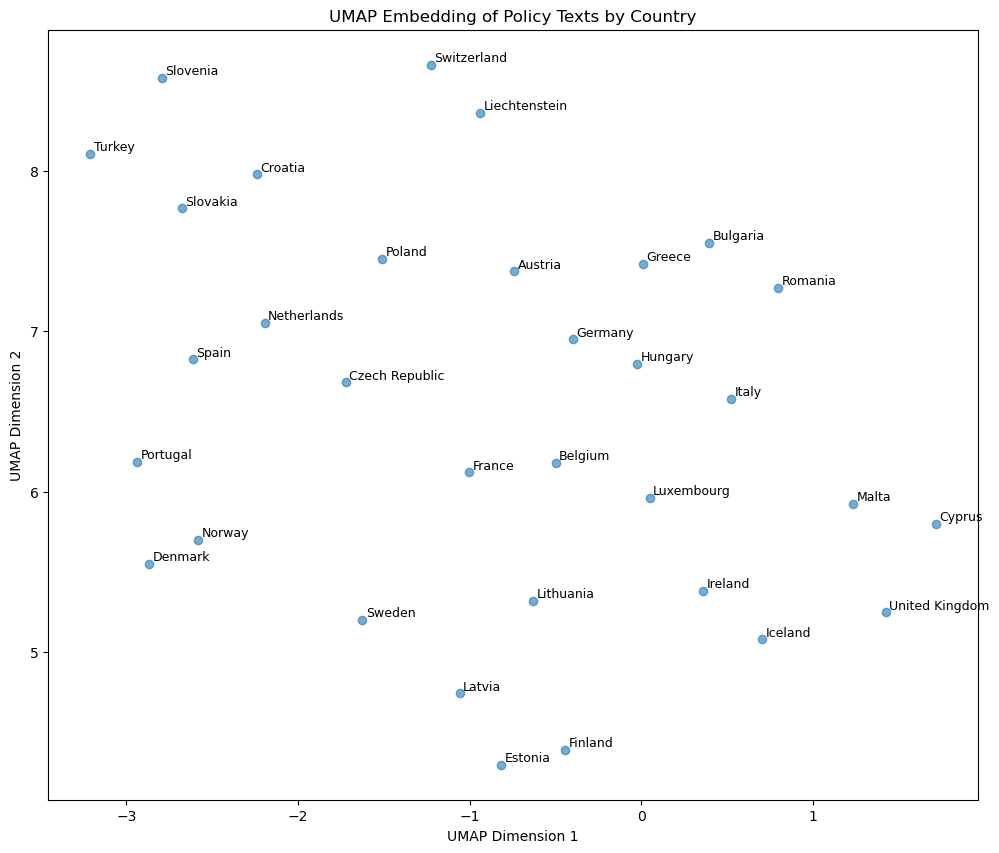

In [15]:
## plot with country names

plt.figure(figsize=(12, 10))
plt.scatter(u_embed[:, 0], u_embed[:, 1], alpha=0.6)

for i, label in enumerate(df['country'].values):
    plt.text(
        u_embed[i, 0] + 0.02,  # small offset so text isn't right on top of the dot
        u_embed[i, 1] + 0.02,
        str(label),
        fontsize=9
    )

plt.title("UMAP Embedding of Policy Texts by Country")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


it appears that points very loosely mirror some geograhpical positions/ neighbours?? (e.g. Estonia, Finland, Latvia, Lithuania and Sweden being nearby?, plus nearby Malta & Cyprus, Norway & Denmark, and Switzerland and Leitchn)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
# X: (n_samples, n_features) numpy array or dataframe of embeddings
S = cosine_similarity(X)   # similarity matrix in [-1,1]
D = 1 - S                  # simple cosine distance in [0,2]


In [24]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering

In [25]:
# try DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=5, metric='cosine')
labels_db = dbscan.fit_predict(X)

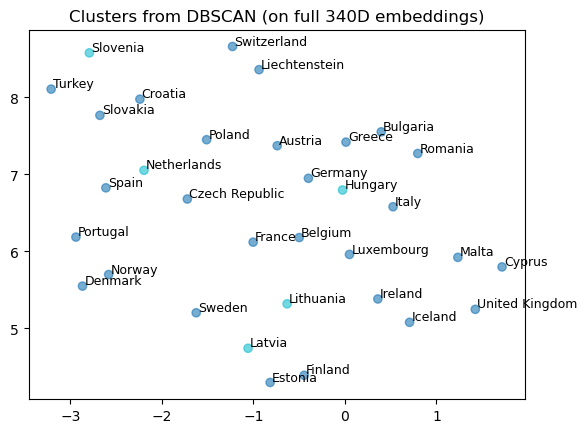

In [27]:
plt.scatter(u_embed[:,0], u_embed[:,1], c=labels_db, cmap='tab10', alpha=0.6)

for i, label in enumerate(df['country'].values):
    plt.text(
        u_embed[i, 0] + 0.02,  # small offset so text isn't right on top of the dot
        u_embed[i, 1] + 0.02,
        str(label),
        fontsize=9
    )

plt.title("Clusters from DBSCAN (on full 340D embeddings)")
plt.show()

In [28]:
from sklearn.metrics.pairwise import cosine_distances

D = cosine_distances(X)
print("Avg intra-cluster distance (cluster 0):", D[labels_db==0][:, labels_db==0].mean())
print("Avg intra-cluster distance (cluster 1):", D[labels_db==1][:, labels_db==1].mean())
print("Avg inter-cluster distance:", D[labels_db==0][:, labels_db==1].mean())

Avg intra-cluster distance (cluster 0): 0.1717368544968574
Avg intra-cluster distance (cluster 1): nan
Avg inter-cluster distance: nan


In [31]:


S = cosine_similarity(X)
D = 1 - S
agg = AgglomerativeClustering(n_clusters=4, metric='precomputed', linkage='average', distance_threshold=None)
labels_agg = agg.fit_predict(D)

spec = SpectralClustering(n_clusters=8, affinity='precomputed')
labels_spec = spec.fit_predict(S)

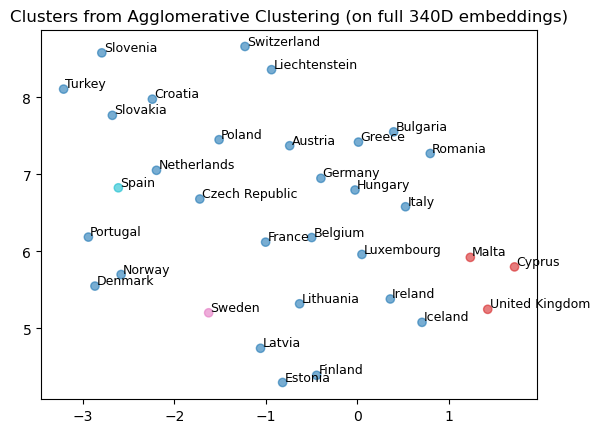

In [32]:
plt.scatter(u_embed[:,0], u_embed[:,1], c=labels_agg, cmap='tab10', alpha=0.6)

for i, label in enumerate(df['country'].values):
    plt.text(
        u_embed[i, 0] + 0.02,  # small offset so text isn't right on top of the dot
        u_embed[i, 1] + 0.02,
        str(label),
        fontsize=9
    )

plt.title("Clusters from Agglomerative Clustering (on full 340D embeddings)")
plt.show()

### currently extremely high dimensional - apply PCA - dimensionality reduction

In [37]:
from sklearn.decomposition import PCA

#note: no need to scale since all values refer to the same dimensional space

# running the PCA model
pca_embeddings = PCA(n_components=5) #'n_components' argument defines the number of components/dimensions/variables we wish to end up with
pca_features = pca_embeddings.fit_transform(X)

# Show PCA characteristics
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (33, 384)
Shape after PCA:  (33, 5)


In [38]:
pca_embeddings.explained_variance_ratio_

array([0.10289953, 0.08268505, 0.06865039, 0.0627079 , 0.06189462])

* PC1 - explains just 10% variance
* PC2 - explains 8%
* PC3 - explains 6%
- together they explain just 24% variance....

In [39]:
pca_embeddings.explained_variance_ # geting eigenvalues for principle components

array([0.03565012, 0.0286467 , 0.02378432, 0.02172551, 0.02144374])

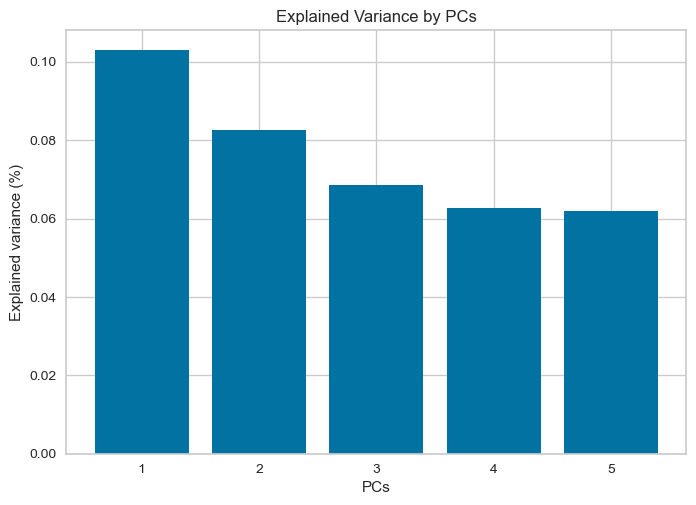

In [40]:
# let's visusalise the explained variance
plt.bar(
    range(1,len(pca_embeddings.explained_variance_ratio_)+1),
    pca_embeddings.explained_variance_ratio_
    )

plt.xlabel('PCs')
plt.ylabel('Explained variance (%)')
plt.title('Explained Variance by PCs')
plt.show()

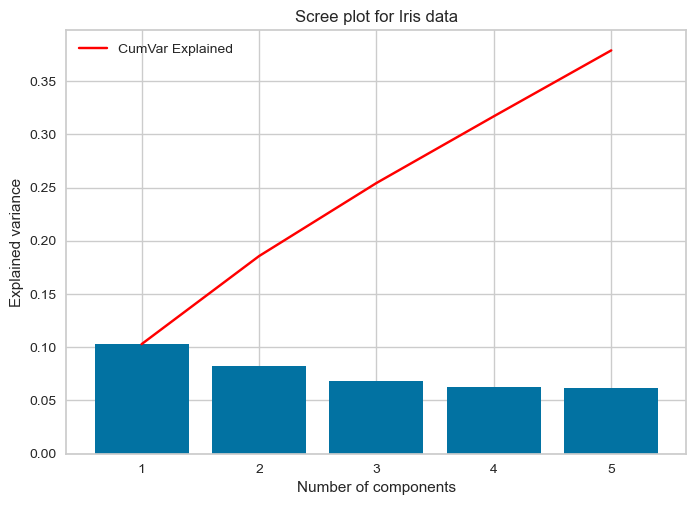

In [41]:
# let' make a scree plot

# this is the bar graph from above
plt.bar(
    range(1,len(pca_embeddings.explained_variance_)+1),
    pca_embeddings.explained_variance_ratio_
    )

# and not let's add the cumulative explained variance line
plt.plot(
    range(1,len(pca_embeddings.explained_variance_ )+1),
    np.cumsum(pca_embeddings.explained_variance_ratio_), # here we define cunmulative sum with the numpy function cumsum
    c='red',
    label='CumVar Explained')

plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Scree plot for Iris data')
plt.show()

now apply kmeans 

In [16]:
k_means = KMeans(n_clusters=3)
k_means.fit(X)

from sklearn import metrics
# run silhouette score to investigate cluster quality, and help determine optimum number of clusters
metrics.silhouette_score(X, k_means.labels_, metric='euclidean')

0.06551145252738291

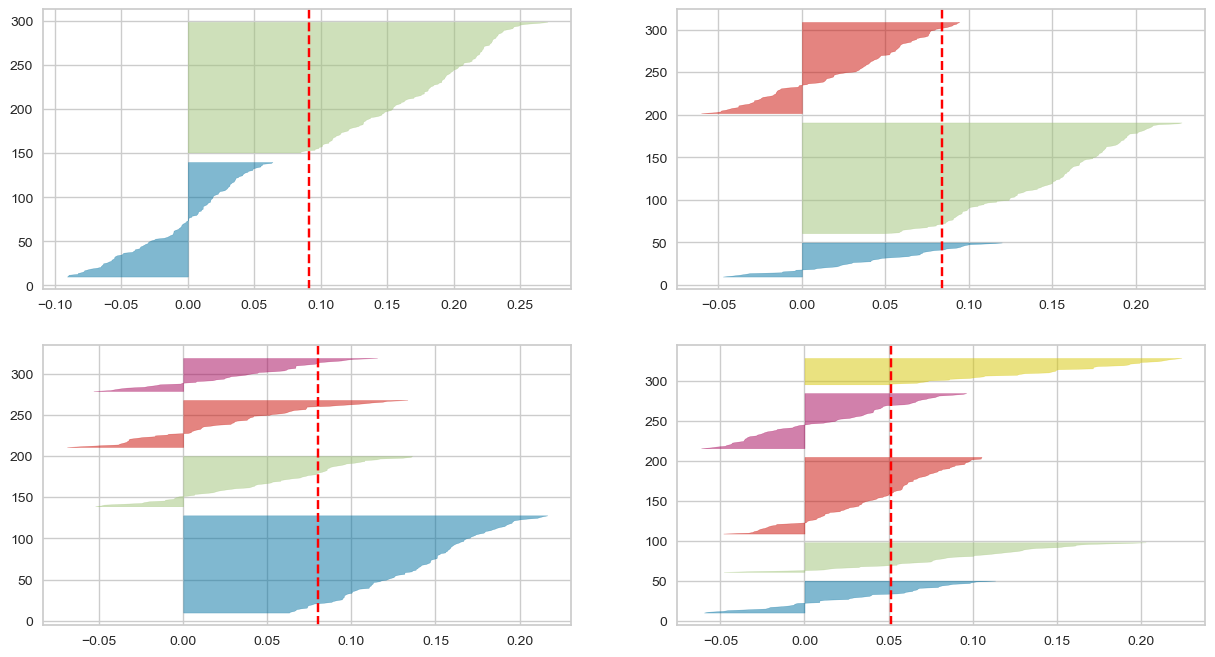

In [26]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X) 

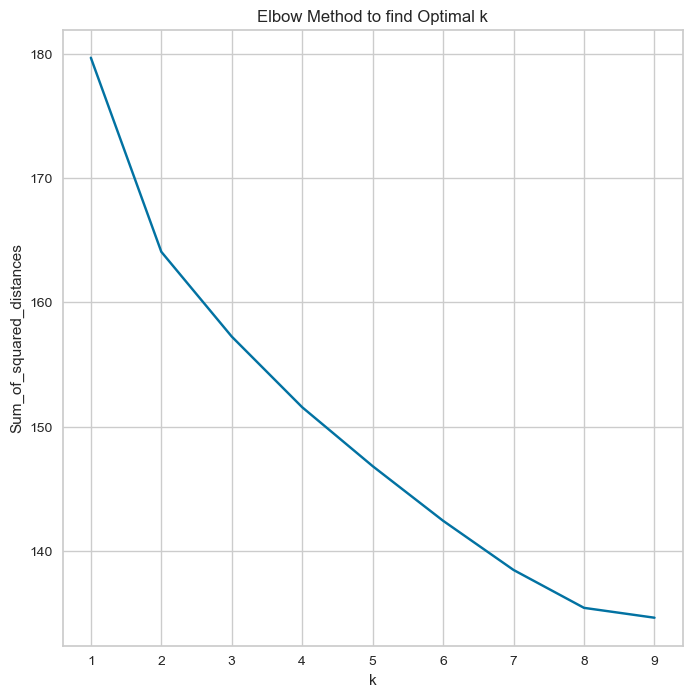

In [18]:
# plot the elbow curve to identify optimal number of clusters
Sum_of_squared_distances=[]
K=np.arange(1,10)
for i in K:
    kmeans=KMeans(n_clusters=i, n_init=10)
    kmeans=kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.figure(figsize=(8,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method to find Optimal k')
plt.show()

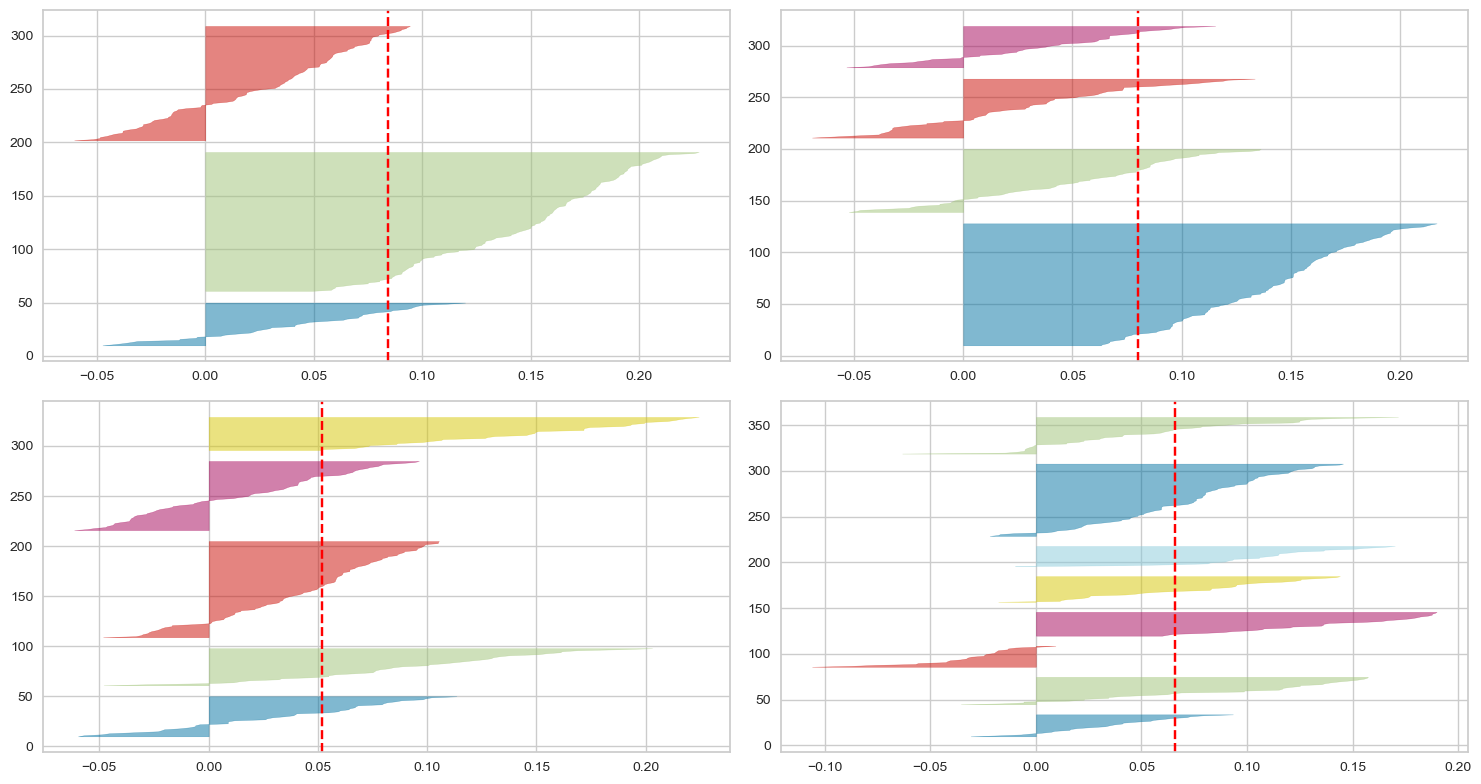

In [20]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# choose cluster counts
cluster_counts = [3, 4, 5, 8]

# create subplots, flatten ax to 1D array
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.ravel()  # now ax[0], ax[1], ax[2], ax[3]

for idx, n_clusters in enumerate(cluster_counts):
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[idx])
    visualizer.fit(X)

plt.tight_layout()
plt.show()


these are all very sharp - not sure k means is going to be the best here? at least not if i'm sub splitting all the policies...

# try hierarchical clustering


In [23]:
# Here again we use the Iris dataset
from sklearn.cluster import AgglomerativeClustering
# training agglomerative clustering model
hc_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward') 
# we can specify n_clusters argument, but this is not necessary as is the case in K-means clustering
hc_model.fit(X)

AgglomerativeClustering(n_clusters=3)

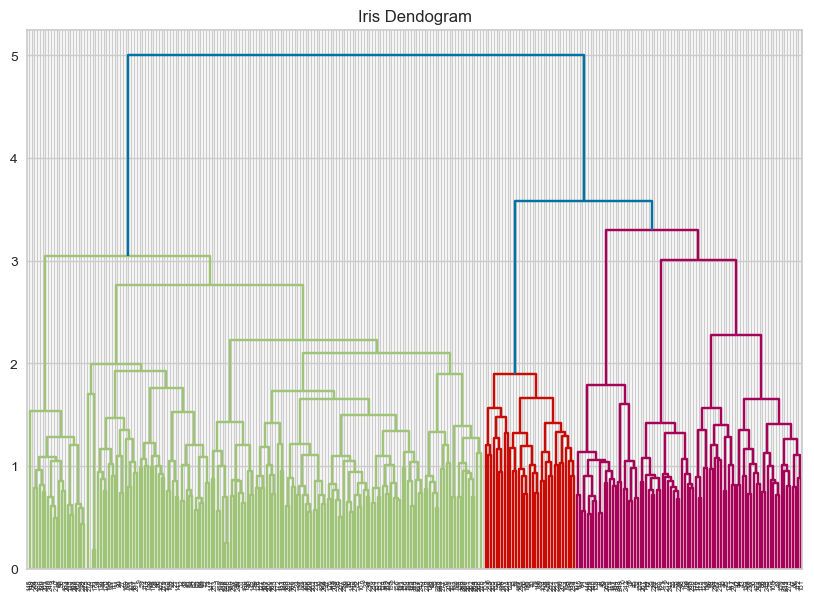

In [24]:
# dendogram
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Iris Dendogram")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

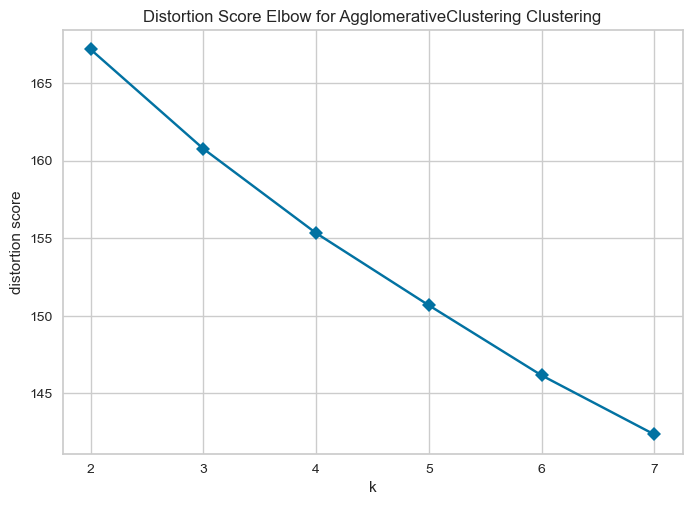

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
# let's crete the Elbow plot by using KElbowVisualiser from the yellowbrick package
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(hc_model, k=(2,8), timings=False)
# Fit data to visualizer
visualizer.fit(X)
# Finalize and render figure
visualizer.show()